In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,
seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = 'serif'

In [129]:
path = "/home/criuser/LPI Courses/Data & IA/Final Project/Data_processed/"

path_image = "/home/criuser/LPI Courses/Data & IA/Final Project/All_pictures/"

data = pd.read_csv(path+"Sales_forecasting_processed_data.csv",
                        parse_dates=['date'],
                        infer_datetime_format=True,
                       index_col="date"
                        )

comparaison = pd.read_csv(path_image+"/comparaison.csv")

In [130]:
def split_data(data, test_size):
    l = len(data)
    t_idx = round(l*(1-test_size))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [131]:
test_size = 0.15

train, test = split_data(data,test_size)

train: 1431 , test: 253


In [132]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \tlags:{results[1]}")
    return (s, results[0])

In [133]:
check_stationarity(data.sales)

('Non-Stationary', 0.08969592175787516)

In [134]:
def get_best_model(score, c='AIC'):
    
    initial_score = score[0][c]
    best_model = 0
    
    for k,v in score.items():
        
        if v[c] < initial_score:
            
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    
    return score[best_model]['model']

In [135]:
def plot_forecast(model, start, train, test):
    
    forecast = pd.DataFrame(model.forecast(test.
    shape[0]),
    index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [136]:
def combinator(items):
    
    combo = [i for i in product(*items)]
    
    return combo

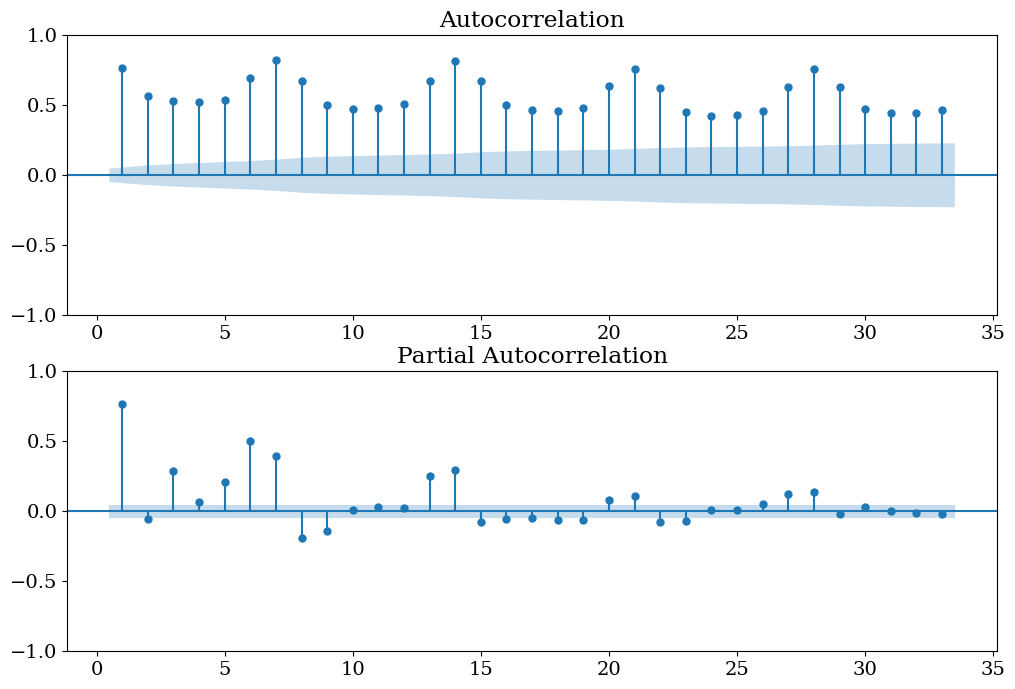

In [137]:
sales = data.sales

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(sales, zero=False, ax=ax[0])
print("\n")
plot_pacf(sales, zero=False, ax=ax[1])
plt.show()

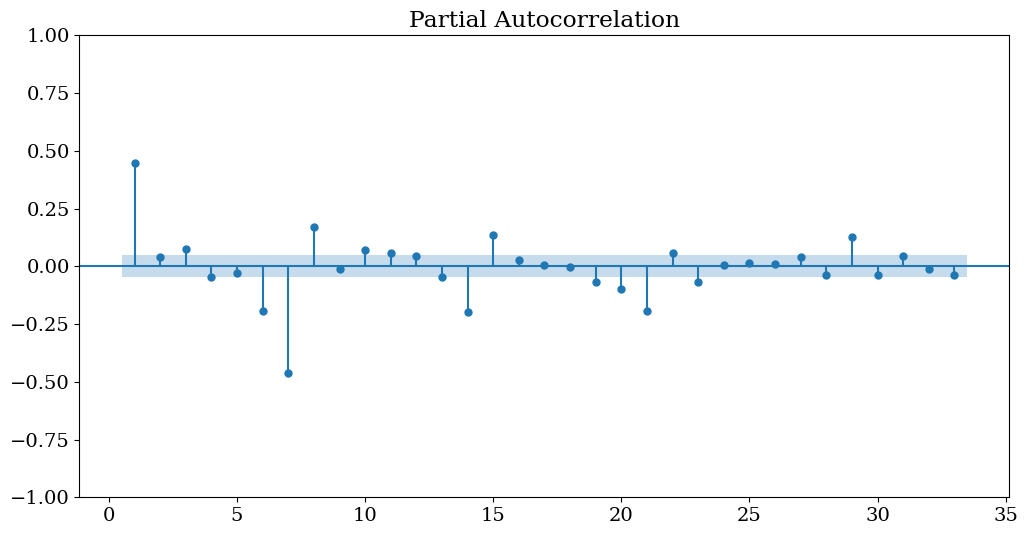

In [138]:
sales_diff = data.sales.diff(7).dropna()

#fig, ax = plt.subplots(2,1, figsize=(12,8))
#plot_acf(sales_diff, zero=False)
print("\n")
plot_pacf(sales_diff, zero=False)
plt.show()

As we can observe in ACF plot the maximum significant order is 33 then MA(33) and for PACF is 27 or AR(27)

In [139]:
check_stationarity(sales_diff)

'Stationary	 p-value:2.139564918532119e-22 	lags:22


('Stationary', 2.139564918532119e-22)

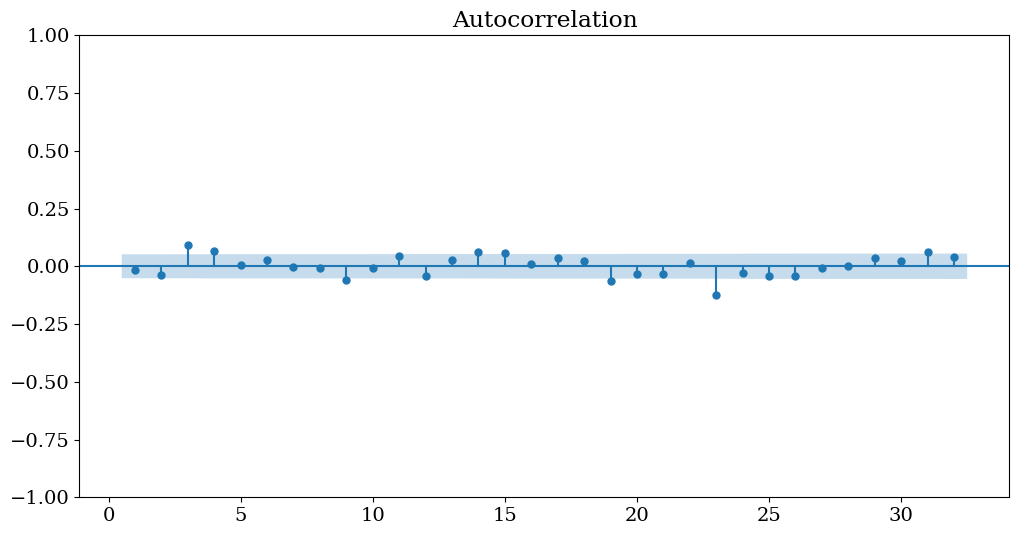

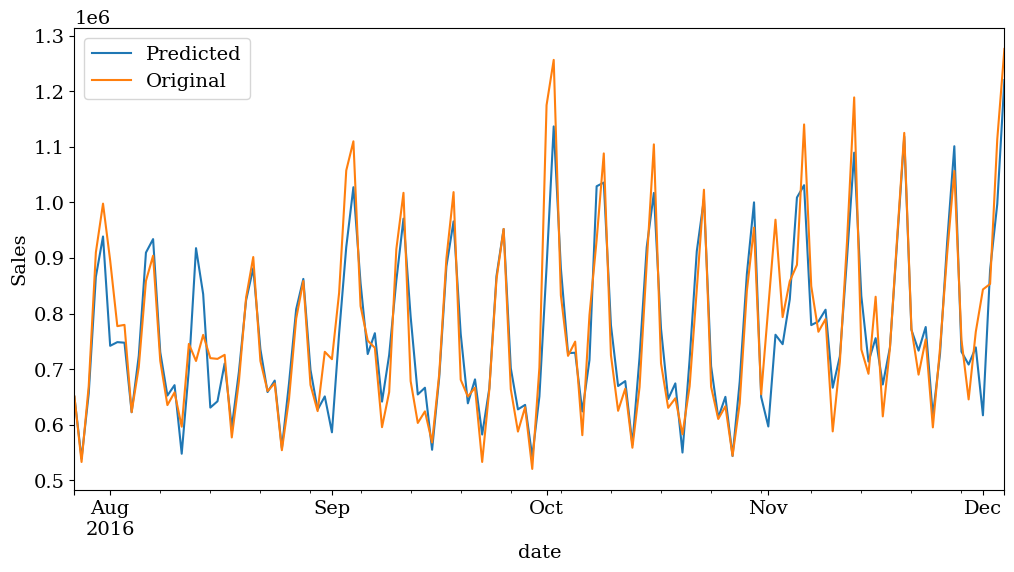

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1431
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -18310.843
Date:                           Mon, 16 Jan 2023   AIC                          36631.686
Time:                                   11:36:56   BIC                          36657.988
Sample:                                        0   HQIC                         36641.510
                                          - 1431                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.021     26.934      0.000       0.514       0.594
ma.L1         -0.9451      0.017    -56.448

In [140]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train.sales, order=(1,1,1),
seasonal_order=(1,1,1,7)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()

model.fittedvalues[1300:].plot(label = "Predicted")
train.sales[1300:].plot(label = "Original")
plt.ylabel("Sales")
plt.legend()
plt.show()

print(model.summary())

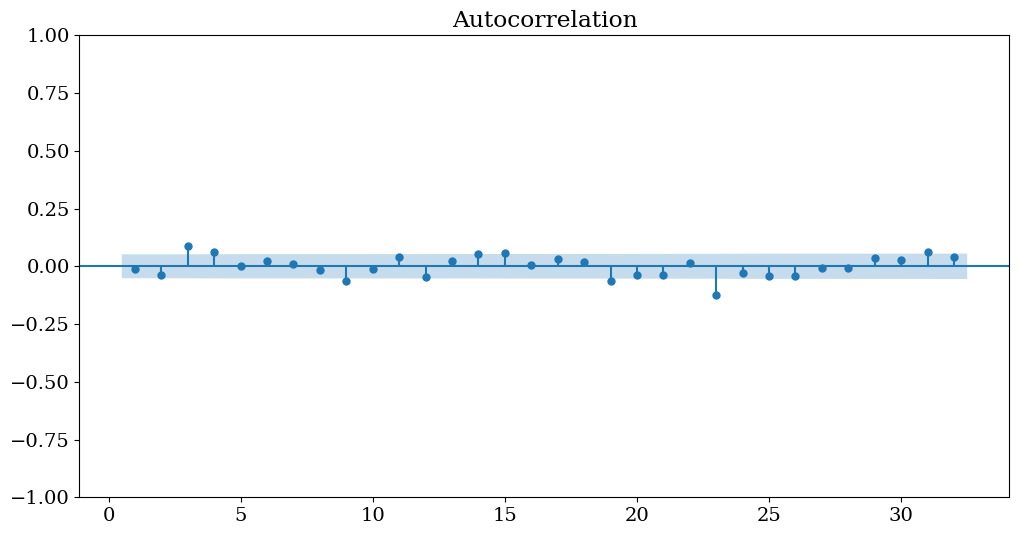

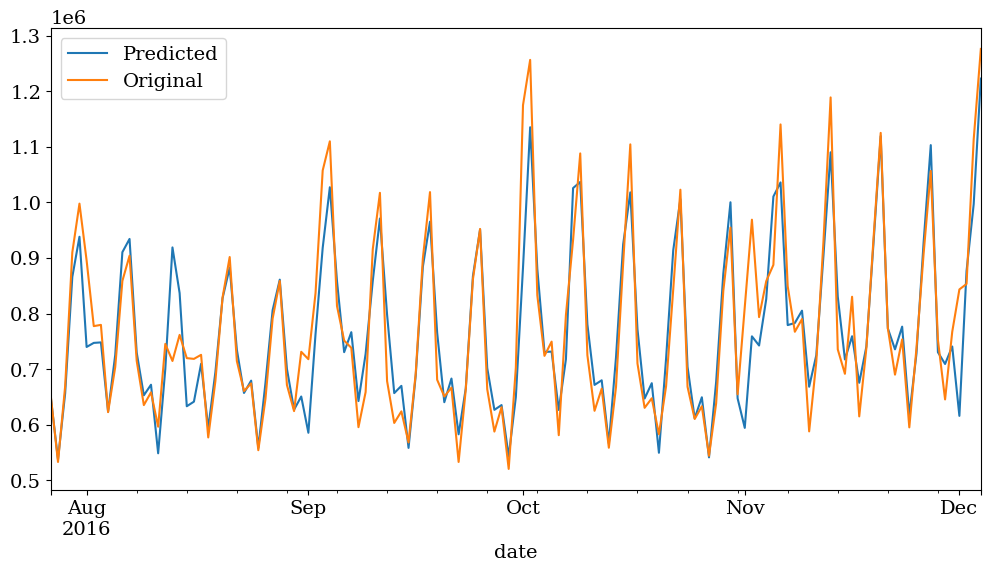

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1431
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -18310.994
Date:                           Mon, 16 Jan 2023   AIC                          36629.988
Time:                                   11:36:58   BIC                          36651.030
Sample:                                        0   HQIC                         36637.847
                                          - 1431                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5375      0.023     23.359      0.000       0.492       0.583
ma.L1         -0.9323      0.020    -47.539

In [141]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(train.sales, order=(1,1,1),
seasonal_order=(0,1,1,7)).fit(disp=False)
plot_acf(model2.resid[1:], zero=False)
plt.show()

model2.fittedvalues[1300:].plot(label = "Predicted")
train.sales[1300:].plot(label = "Original")
plt.legend()
plt.show()

print(model2.summary())

In [142]:
def get_info_forecast(model,n, title = "Forecast with SARIMAX"):

    forecast = model.get_forecast(n)

    confint = forecast.conf_int()

    plt.title(title)
    plt.plot(test.index[:n],forecast.predicted_mean[:n],label="Predicted")
    plt.plot(test.sales[:n], label = "Original")
    plt.plot(test.index[:n],confint["upper sales"],"g--",label = "confint")
    plt.plot(test.index[:n],confint["lower sales"],"g--")
    plt.fill_between(test.index[:n],confint["lower sales"],confint["upper sales"],color='silver')
    plt.xticks(rotation=45)
    plt.ylabel("Sales")
    plt.legend()
    plt.savefig(path_image+f"/{title[:8]}.png")
    plt.show()

    print("=="*55)
    print(" "*54+"Metrics"+" "*54)
    print("=="*55)
    mape_value = mape(forecast.predicted_mean[:n],test.sales[:n])
    rmse_value = rmse(forecast.predicted_mean[:n],test.sales[:n])
    rmspe_value = rmspe(test.sales[:n],forecast.predicted_mean[:n])
    print(f"Mean average percentage error: {mape_value:.2%}")
    print(f"Root mean percentage error: {rmspe_value:.2%}")
    print(f"Root mean square error: {rmse_value:.2f}")
    print("=="*55)


    model.plot_diagnostics(figsize = (12, 8))
    plt.savefig(path_image+f"/{title[-8:]}+diag.png")
    plt.show()

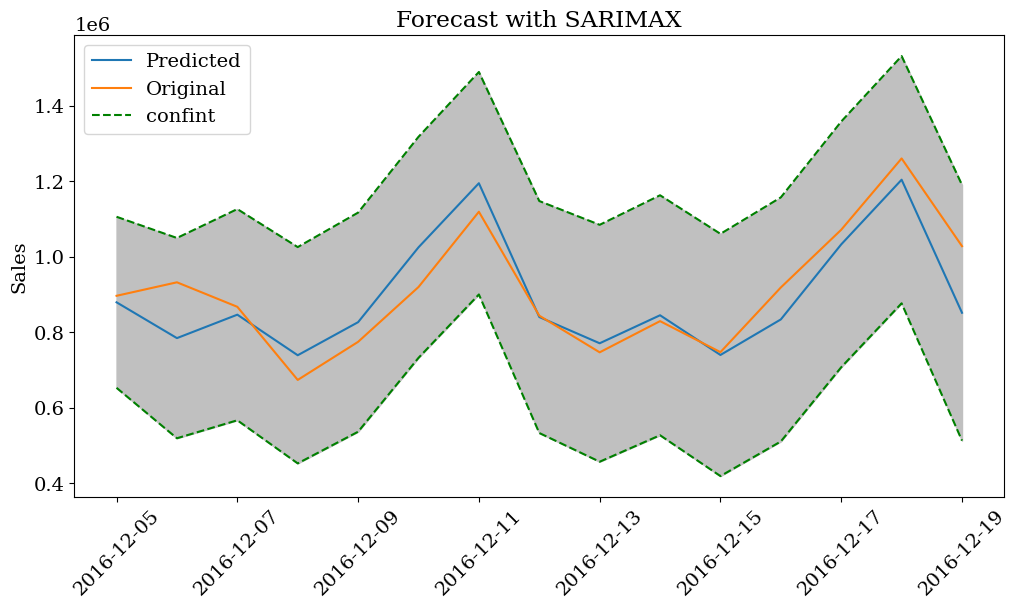

                                                      Metrics                                                      
Mean average percentage error: 6.71%
Root mean percentage error: 81.76%
Root mean square error: 77507.31


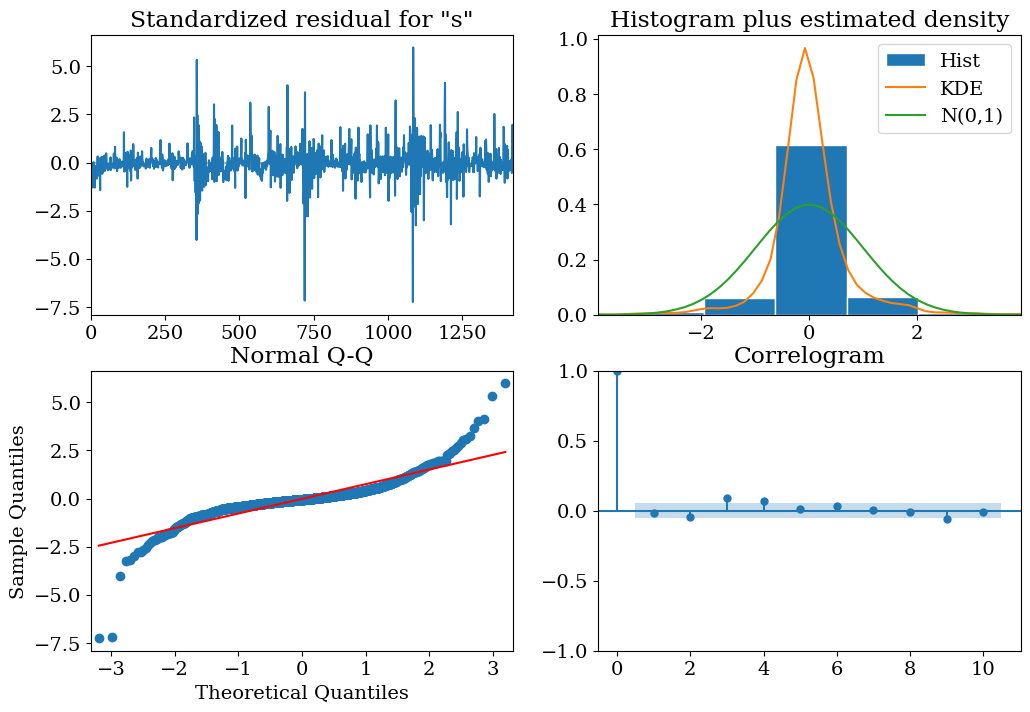

In [143]:
get_info_forecast(model, n = 15, title = "Forecast with SARIMAX")

In [144]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal,normal_ad

def is_normal(test, p_level=0.05):
    
    stat, pval = test
    print("P value: ",pval)
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [145]:
print(is_normal(shapiro(model.resid)))

P value:  9.395683782522469e-39
Not Normal


In [146]:
from statsmodels.stats.api import (het_breuschpagan,het_goldfeldquandt, het_white)
import statsmodels.api as sm

def het_test(model, test=het_breuschpagan):
    
    lm, lm_pvalue, fvalue, f_pvalue = (het_breuschpagan(model.resid,sm.add_constant(model.fittedvalues)))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

print(het_test(model, test=het_breuschpagan))

Heteroskedastic


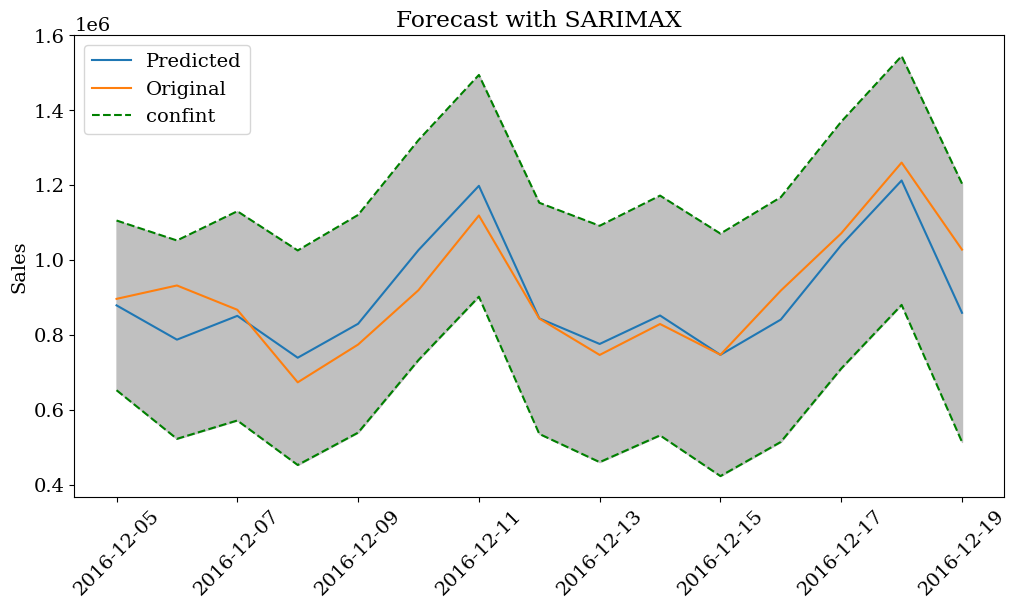

                                                      Metrics                                                      
Mean average percentage error: 6.47%
Root mean percentage error: 80.18%
Root mean square error: 75549.16


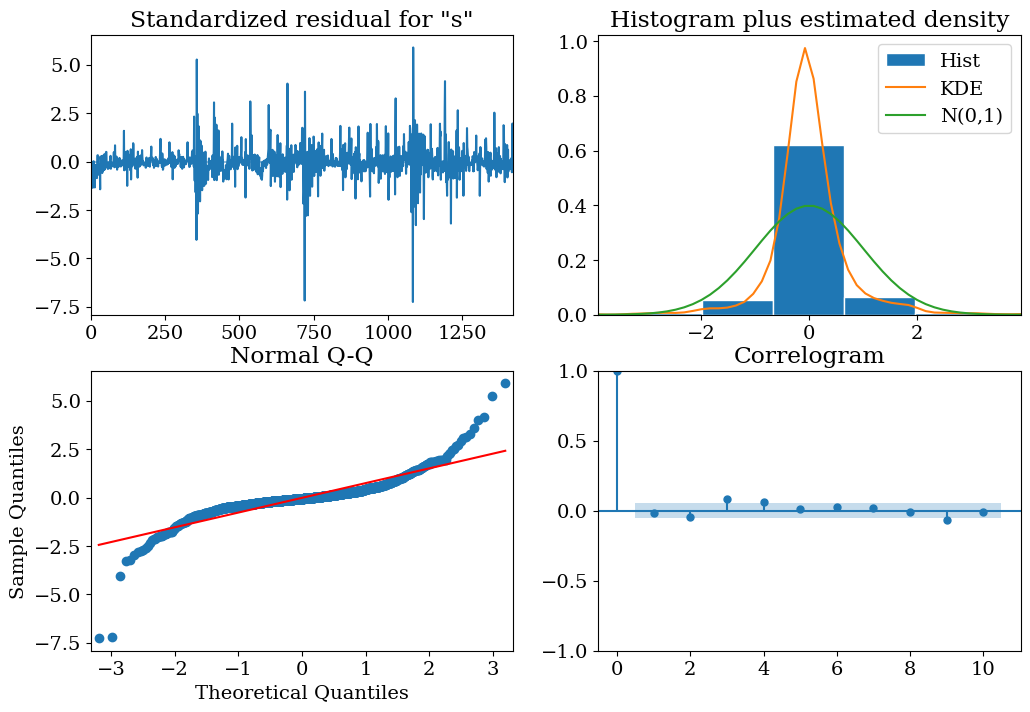

In [147]:
get_info_forecast(model2,n = 15, title = "Forecast with SARIMAX")

In [148]:
comparaison

,Model Name,RMSE,MAPE,MASE
0,Linear Regression,134962.952963,0.111330,0.857603
1,Elastic Net,136062.029994,0.114330,0.876584
2,Ridge Regression,134962.478188,0.111333,0.857607
3,Lasso Regression,134962.982499,0.111330,0.857599
4,Huber Regression,164241.905730,0.139957,1.068461


In [149]:
comparaison.loc[len(comparaison)] = ["SARIMA",75549.16,0.0647,0.8018]

In [150]:
comparaison

,Model Name,RMSE,MAPE,MASE
0,Linear Regression,134962.952963,0.111330,0.857603
1,Elastic Net,136062.029994,0.114330,0.876584
2,Ridge Regression,134962.478188,0.111333,0.857607
3,Lasso Regression,134962.982499,0.111330,0.857599
4,Huber Regression,164241.905730,0.139957,1.068461
5,SARIMA,75549.160000,0.064700,0.801800


In [151]:
print(model2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1431
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -18310.994
Date:                           Mon, 16 Jan 2023   AIC                          36629.988
Time:                                   11:37:01   BIC                          36651.030
Sample:                                        0   HQIC                         36637.847
                                          - 1431                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5375      0.023     23.359      0.000       0.492       0.583
ma.L1         -0.9323      0.020    -47.539

In [152]:
print(het_test(model2, test=het_breuschpagan))

print(is_normal(shapiro(model2.resid)))

Heteroskedastic
P value:  8.288387545102249e-39
Not Normal


# Exponential Smoothing

In [153]:
from statsmodels.tsa.api import ExponentialSmoothing

In [154]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])

sales_train = train.sales

y = test.sales

score = {}

for i, (t, dp) in enumerate(life_ex_comb):

    exp = ExponentialSmoothing(sales_train,
                               trend=t,
                               damped_trend=dp,
                               seasonal=None)

    model3 = exp.fit(use_brute=True, optimized=True)

    y_hat = model3.forecast(len(y))

    score[i] = {'trend':t,
                'damped':dp,
                'AIC':model3.aic,
                'BIC':model3.bic,
                'AICc':model3.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model3}

In [155]:
sales_best_model = get_best_model(score, 'AIC')

Best model: 0 with lowest AIC score: 34004.695324042616


In [156]:
print(sales_best_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                 1431
Model:             ExponentialSmoothing   SSE                 29695910941064.203
Optimized:                         True   AIC                          34004.695
Trend:                         Additive   BIC                          34031.026
Seasonal:                          None   AICC                         34004.774
Seasonal Periods:                  None   Date:                 Mon, 16 Jan 2023
Box-Cox:                          False   Time:                         11:37:02
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1464286                alpha                 True
smoothing_trend               0.00

In [157]:
def get_info_forecast_expo(model,n, title = "Forecast with SARIMAX"):

    forecast = model.forecast(n)

#    confint = forecast.conf_int()

    plt.title(title)
    plt.plot(test.index[:n],forecast[:n],label="Predicted")
    plt.plot(test.sales[:n], label = "Original")
#    plt.plot(test.index[:n],confint["upper sales"],"g--",label = "confint")
#    plt.plot(test.index[:n],confint["lower sales"],"g--")
    plt.xticks(rotation=45)
    plt.savefig(path_image+f"/{title}.png")
    plt.legend()
    plt.show()

    print("=="*55)
    print(" "*54+"Metrics"+" "*54)
    print("=="*55)
    mape_value = mape(forecast[:n],test.sales[:n])
    rmse_value = rmse(forecast[:n],test.sales[:n])
    rmspe_value = rmspe(test.sales[:n],forecast[:n])
    print(f"Mean average percentage error: {mape_value:.2%}")
    print(f"Root mean percentage error: {rmspe_value:.2%}")
    print(f"Root mean square error: {rmse_value:.2f}")
    print("=="*55)

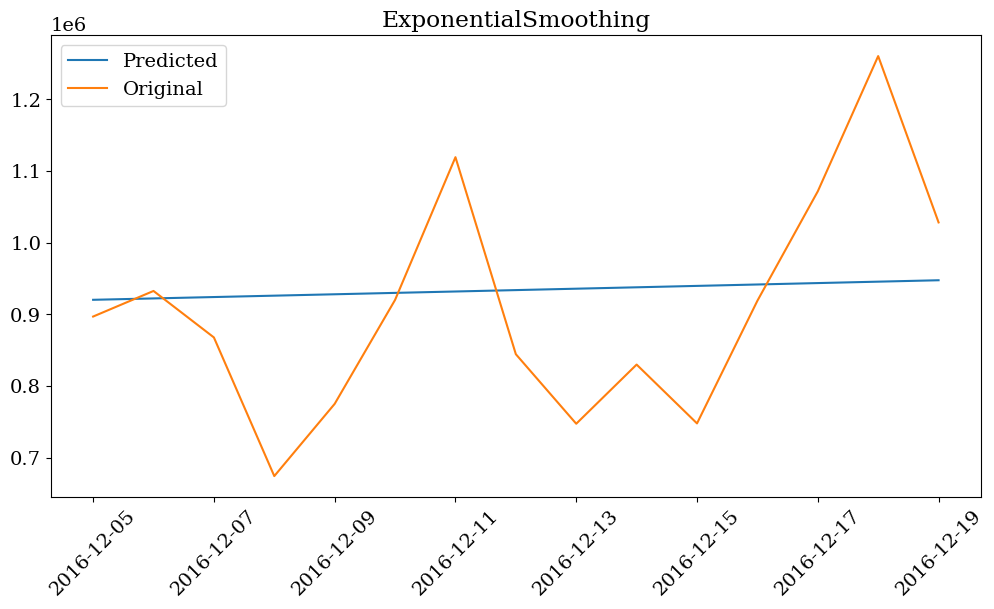

                                                      Metrics                                                      
Mean average percentage error: 12.94%
Root mean percentage error: 173.80%
Root mean square error: 150697.61


In [158]:
get_info_forecast_expo(model3,n=15, title = "ExponentialSmoothing")

In [159]:
comparaison.loc[len(comparaison)] = ["ExponentialSmooting",150697.61,0.1294,1.7380]

In [160]:
comparaison

,Model Name,RMSE,MAPE,MASE
0,Linear Regression,134962.952963,0.111330,0.857603
1,Elastic Net,136062.029994,0.114330,0.876584
2,Ridge Regression,134962.478188,0.111333,0.857607
3,Lasso Regression,134962.982499,0.111330,0.857599
4,Huber Regression,164241.905730,0.139957,1.068461
5,SARIMA,75549.160000,0.064700,0.801800
6,ExponentialSmooting,150697.610000,0.129400,1.738000


In [161]:
print(het_test(model3, test=het_breuschpagan))

Heteroskedastic


# Automatique ARIMA

In [162]:
import pmdarima as pm

In [163]:
auto_model = pm.auto_arima(train.sales,
                           seasonal = True,
                           m = 5,
                           test = 'adf',
                           stepwise = True,
                          trace = True)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=inf, Time=6.62 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=39247.905, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=37864.804, Time=1.06 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=38398.611, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=42304.796, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=37964.504, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[5] intercept   : AIC=37839.374, Time=2.67 sec
 ARIMA(1,0,0)(2,0,1)[5] intercept   : AIC=37834.245, Time=3.99 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=37865.368, Time=2.20 sec
 ARIMA(1,0,0)(2,0,2)[5] intercept   : AIC=inf, Time=9.14 sec
 ARIMA(1,0,0)(1,0,2)[5] intercept   : AIC=37810.646, Time=5.90 sec
 ARIMA(1,0,0)(0,0,2)[5] intercept   : AIC=37879.440, Time=1.04 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=37890.606, Time=0.50 sec
 ARIMA(0,0,0)(1,0,2)[5] intercept   : AIC=38952.532, Time=4.19 sec
 ARIMA(2,0,0)(1,0,2)[5] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1431
Model:             SARIMAX(4, 0, 0)x(2, 0, [1, 2], 5)   Log Likelihood              -18626.389
Date:                                Mon, 16 Jan 2023   AIC                          37272.779
Time:                                        11:41:59   BIC                          37325.440
Sample:                                             0   HQIC                         37292.443
                                               - 1431                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.005e+05   3.05e+04      3.295      0.001    4.07e+04     1.6e+05
ar.L1          0.5181      0.024     21.356      0.000       0.471       0.566
ar.L2         -0.1530      0.031     -4.931      0.000      -0.214      -0.092
ar.L3          0.4572      0.032     14.359      0.000       0.395       0.520
ar.L4          0.1069      0.035      3.034      0.002       0.038       0.176
ar.S.L5       -0.4209      0.006    -69.103      0.000      -0.433      -0.409
ar.S.L10      -0.9869      0.007   -150.213      0.000      -1.000      -0.974
ma.S.L5        0.3448      0.023     15.136      0.000       0.300       0.389
ma.S.L10       0.8788      0.024     36.666      0.000       0.832       0.926
sigma2      1.711e+10      0.382   4.48e+10      0.000    1.71e+10    1.71e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1881.41
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+33. Standard errors may be unstable.
"""

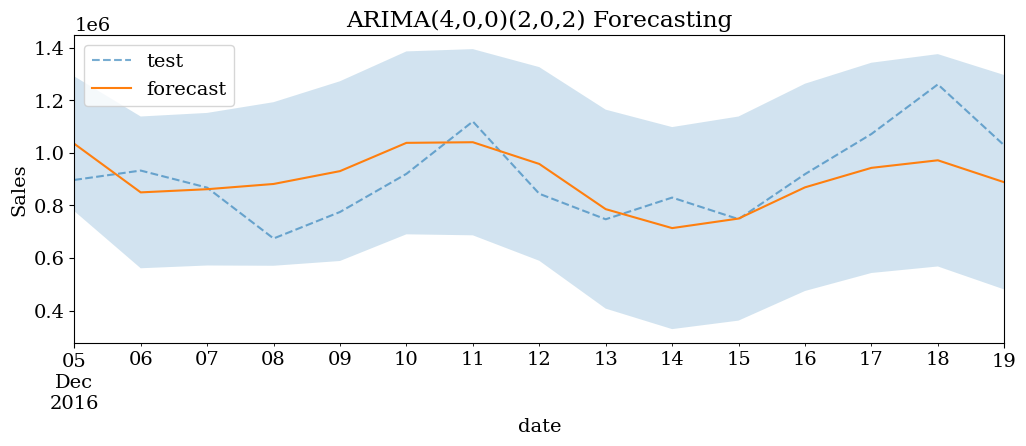

                                                      Metrics                                                      
Mean average percentage error: 12.09%
Root mean percentage error: 145.32%
Root mean square error: 132488.01


In [164]:
n = 15
forecast, conf_interval = auto_model.predict(n_periods=n,return_conf_int=True)

lower_ci, upper_ci = zip(*conf_interval)
index = test.index[:n]
ax = test.sales[:n].plot(style='--', alpha=0.6, figsize=(12,4))
plt.plot(index,forecast)
plt.fill_between(index[:n], lower_ci, upper_ci, alpha=0.2)
plt.ylabel("Sales")
plt.legend(['test', 'forecast']) 
plt.title("ARIMA(4,0,0)(2,0,2) Forecasting")
plt.savefig(path_image+"/ARIMA.png")
plt.show()

print("=="*55)
print(" "*54+"Metrics"+" "*54)
print("=="*55)
mape_value = mape(forecast[:n],test.sales[:n])
rmse_value = rmse(forecast[:n],test.sales[:n])
rmspe_value = rmspe(test.sales[:n],forecast[:n])
print(f"Mean average percentage error: {mape_value:.2%}")
print(f"Root mean percentage error: {rmspe_value:.2%}")
print(f"Root mean square error: {rmse_value:.2f}")
print("=="*55)

In [165]:
comparaison.loc[len(comparaison)] = ["ARIMA",132488.01,0.1209,1.4532]

In [166]:
comparaison

,Model Name,RMSE,MAPE,MASE
0,Linear Regression,134962.952963,0.111330,0.857603
1,Elastic Net,136062.029994,0.114330,0.876584
2,Ridge Regression,134962.478188,0.111333,0.857607
3,Lasso Regression,134962.982499,0.111330,0.857599
4,Huber Regression,164241.905730,0.139957,1.068461
5,SARIMA,75549.160000,0.064700,0.801800
6,ExponentialSmooting,150697.610000,0.129400,1.738000
7,ARIMA,132488.010000,0.120900,1.453200


# Prophet Model

In [167]:
from prophet import Prophet

In [168]:
model4 = Prophet().fit(train.sales.reset_index().rename(columns={"date":"ds","sales":"y"}))

11:42:00 - cmdstanpy - INFO - Chain [1] start processing
11:42:00 - cmdstanpy - INFO - Chain [1] done processing


In [169]:
Future = model4.make_future_dataframe(15,freq='D')[1431:]

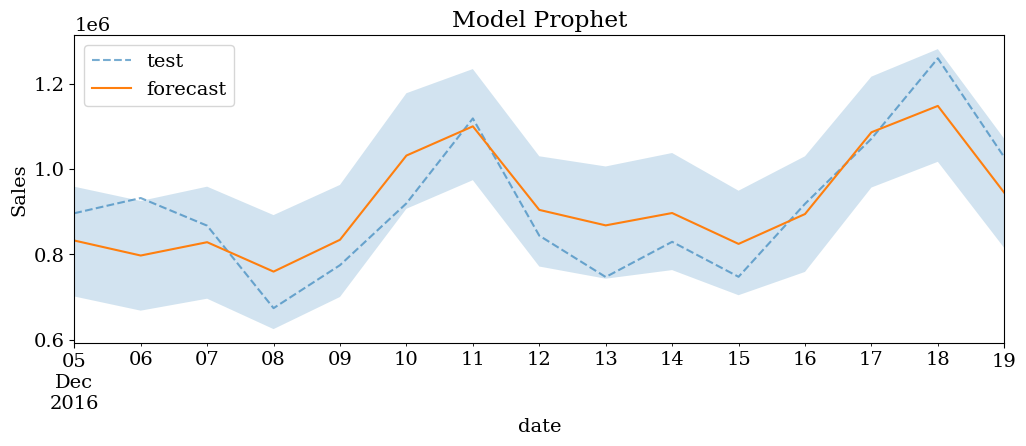

                                                      Metrics                                                      
Mean average percentage error: 8.03%
Root mean percentage error: 92.85%
Root mean square error: 80313.99


In [170]:
n = 15
forecast = model4.predict(Future)

lower_ci, upper_ci = forecast.yhat_lower,forecast.yhat_upper

index = test.index[:n]
ax = test.sales[:n].plot(style='--', alpha=0.6, figsize=(12,4))
plt.title("Model Prophet")
plt.plot(index,forecast.yhat)
plt.fill_between(index[:n], lower_ci, upper_ci, alpha=0.2)
plt.ylabel("Sales")
plt.legend(['test', 'forecast'])
plt.savefig(path_image+"/prophet.png")
plt.show()

print("=="*55)
print(" "*54+"Metrics"+" "*54)
print("=="*55)
mape_value = mape(forecast.yhat[:n],test.sales[:n])
rmse_value = rmse(forecast.yhat[:n],test.sales[:n])
rmspe_value = rmspe(test.sales[:n],forecast.yhat[:n])
print(f"Mean average percentage error: {mape_value:.2%}")
print(f"Root mean percentage error: {rmspe_value:.2%}")
print(f"Root mean square error: {rmse_value:.2f}")
print("=="*55)

In [171]:
comparaison.loc[len(comparaison)] = ["Prophet",80313.99,0.0803,0.9285]

In [176]:
comparaison = comparaison[["Model Name","RMSE","MAPE"]].sort_values(by="MAPE")

In [177]:
import dataframe_image as dfi
dfi.export(comparaison,path_image+"/comparaison_table.png")

[0116/114736.779845:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0

[0116/114736.827842:WARNING:sandbox_linux.cc(385)] InitializeSandbox() called with multiple threads in process gpu-process.
[0116/114736.945133:INFO:headless_shell.cc(223)] 52637 bytes written to file /tmp/tmp_k4faav7/temp.png
